In [22]:
# Dependencies and setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import requests
import json
import time 
from scipy.stats import linregress

from citipy import citipy
from datetime import date

#Import API key 
weather_api_key = "4343bc3726df924a38d9c0897b39a1a9"

#Output File (CSV)
output_data_file = "output/cities.csv"

# Create range of lats and lons
lat_range = (-90,90)
lng_range = (-180,180)

today = date.today()

In [5]:
#List for holding the lat_lon and cities
lat_lng = []
cities = []

#Create random combinations of latitude and longitude 
lats = np.random.uniform(lat_range[0],lat_range[1], size = 1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size = 1500)
lat_lngs = zip(lats, lngs)

#Generate the nearest city for each random combo
for i in lat_lngs:
    city = citipy.nearest_city(i[0], i[1]).city_name

    if city not in cities:
        cities.append(city)

print(len(cities))

633


Make API Calls

In [6]:
#Perform a weather check on each city using a series of successive API calls.
#Include a print log of each city as it's being processed (with the city number and city name).

unit = 'imperial'

url = f"http://api.openweathermap.org/data/2.5/weather?appid={weather_api_key}&units={unit}"

city_data = []

record_count = 1 
set_count = 1 

# Loop through all the cities in our list
for i, city in enumerate(cities):
        
    # Group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count += 1
        record_count = 0

    # Create endpoint URL with each city
    city_url = url + "&q=" + city
    
    # Log the url, record, and set numbers
    print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))

    print(city_url)

    # Add 1 to the record count
    record_count += 1

# Run an API request for each of the cities
    try:
        # Parse the JSON and retrieve data
        city_weather = requests.get(city_url).json()

        # Parse out the max temp, humidity, and cloudiness
        city_lat = city_weather["coord"]["lat"]
        city_lng = city_weather["coord"]["lon"]
        city_max_temp = city_weather["main"]["temp_max"]
        city_humidity = city_weather["main"]["humidity"]
        city_clouds = city_weather["clouds"]["all"]
        city_wind = city_weather["wind"]["speed"]
        city_country = city_weather["sys"]["country"]
        city_date = city_weather["dt"]

        # Append the City information into city_data list
        city_data.append({"City": city, 
                          "Lat": city_lat, 
                          "Lng": city_lng, 
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})

 # If an error is experienced, skip the city
    except:
        print("City not found. Skipping...")
        pass
              
# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

cessing Record 5 of Set 11 | nemuro
http://api.openweathermap.org/data/2.5/weather?appid=4343bc3726df924a38d9c0897b39a1a9&units=imperial&q=nemuro
Processing Record 6 of Set 11 | hobyo
http://api.openweathermap.org/data/2.5/weather?appid=4343bc3726df924a38d9c0897b39a1a9&units=imperial&q=hobyo
Processing Record 7 of Set 11 | rundu
http://api.openweathermap.org/data/2.5/weather?appid=4343bc3726df924a38d9c0897b39a1a9&units=imperial&q=rundu
Processing Record 8 of Set 11 | olafsvik
http://api.openweathermap.org/data/2.5/weather?appid=4343bc3726df924a38d9c0897b39a1a9&units=imperial&q=olafsvik
Processing Record 9 of Set 11 | dalvik
http://api.openweathermap.org/data/2.5/weather?appid=4343bc3726df924a38d9c0897b39a1a9&units=imperial&q=dalvik
Processing Record 10 of Set 11 | kayerkan
http://api.openweathermap.org/data/2.5/weather?appid=4343bc3726df924a38d9c0897b39a1a9&units=imperial&q=kayerkan
Processing Record 11 of Set 11 | novobiryusinskiy
http://api.openweathermap.org/data/2.5/weather?appid=4

In [7]:
# Convert array of JSONs into Pandas DataFrame
CityWeather= pd.DataFrame(city_data)

# Show Record Count
CityWeather.count()

City          588
Lat           588
Lng           588
Max Temp      588
Humidity      588
Cloudiness    588
Wind Speed    588
Country       588
Date          588
dtype: int64

In [9]:
# Display the City Data Frame
CityWeather

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,mezen,65.85,44.24,49.15,94,100,6.60,RU,1601330423
1,luau,-10.71,22.22,73.53,69,100,6.17,AO,1601330424
2,vaini,-21.20,-175.20,78.80,83,40,5.82,TO,1601330424
3,puro,12.48,123.38,80.53,79,54,1.61,PH,1601330425
4,mantua,45.17,10.78,54.00,85,21,1.99,IT,1601330425
...,...,...,...,...,...,...,...,...,...
583,north bend,43.41,-124.22,91.40,26,1,16.11,US,1601330594
584,turukhansk,65.82,87.98,29.84,97,0,10.69,RU,1601330594
585,seoul,37.57,126.98,57.20,100,1,1.45,KR,1601330308
586,khani,41.96,42.96,73.40,43,1,25.28,GE,1601330595


Remove cities where humidity > 100%

In [13]:
#Filtering out cities that have humidities that are not feasable.
toohumid = CityWeather.loc[CityWeather['Humidity'] > 100]
CityWeather=CityWeather.loc[CityWeather['Humidity'] <= 100]

In [14]:
#  Get the indices of cities that have humidity over 100%.
print(f'There are {len(toohumid)} entries with humidity over 100%')

There are 0 entries with humidity over 100%


In [16]:
#making sure all variables are equal and no missing data

counts = CityWeather.count()
countsinfo = CityWeather.describe()
print(counts)
countsinfo

City          588
Lat           588
Lng           588
Max Temp      588
Humidity      588
Cloudiness    588
Wind Speed    588
Country       588
Date          588
dtype: int64


,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,588.000000,588.000000,588.000000,588.000000,588.00000,588.000000,5.880000e+02
mean,21.316616,15.073197,64.131820,73.253401,52.82483,7.869949,1.601330e+09
std,32.708551,89.466353,16.949313,20.578650,37.94650,5.333246,8.144287e+01
min,-54.800000,-179.170000,13.280000,10.000000,0.00000,0.450000,1.601330e+09
25%,-3.762500,-61.155000,50.000000,66.000000,16.75000,3.600000,1.601330e+09
50%,23.300000,18.395000,67.930000,79.000000,60.50000,6.930000,1.601331e+09
75%,48.892500,91.902500,77.000000,88.000000,90.00000,10.437500,1.601331e+09
max,78.220000,179.320000,98.010000,100.000000,100.00000,31.290000,1.601331e+09


In [20]:
# Extract relevant fields from the data frame
scatterplotdata = CityWeather[['City', 'Lat', 'Max Temp', 'Humidity', 'Cloudiness', 'Wind Speed']]

# Export the city_data into a csv
scatterplotdata.to_csv(r'/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/DataforScatterplots.csv', index = False)

scatterplotdata.head(20)

,City,Lat,Max Temp,Humidity,Cloudiness,Wind Speed
0,mezen,65.85,49.15,94,100,6.60
1,luau,-10.71,73.53,69,100,6.17
2,vaini,-21.20,78.80,83,40,5.82
3,puro,12.48,80.53,79,54,1.61
4,mantua,45.17,54.00,85,21,1.99
5,qandala,11.47,85.32,62,1,1.03
6,ribeira grande,38.52,68.72,85,100,21.52
7,souillac,-20.52,73.40,83,75,10.29
8,geraldton,-28.77,50.00,87,0,10.29
9,hilo,19.73,84.20,66,20,9.17


Latitude vs. Temperature

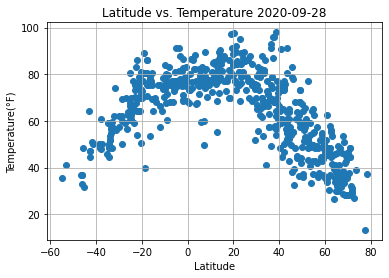

In [29]:
#creating x & y var
#x var will be able to be used in all charts and will not have to be recreated
x = scatterplotdata['Lat']
y1 = scatterplotdata['Max Temp']
#plotting scatter
plt.scatter(x,y1)
#adding labels & Title
plt.xlabel('Latitude')
plt.ylabel('Temperature(°F)')
plt.title(f'Latitude vs. Temperature {today}')

# Save the figure
plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig1.png")

#adding Grid
plt.grid()

Latitude vs. Humidity

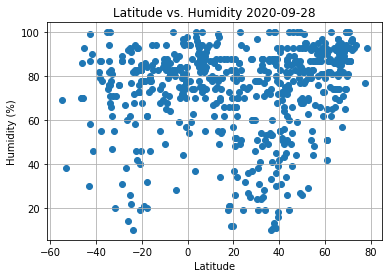

In [30]:
#create var for humidity
y2 = scatterplotdata['Humidity']
#plot scatter graph
plt.scatter(x,y2)

#adding titles/labels
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title(f'Latitude vs. Humidity {today}')
plt.grid()

#saving figure
plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig2.png")

plt.show()

Latitude vs. Cloudiness

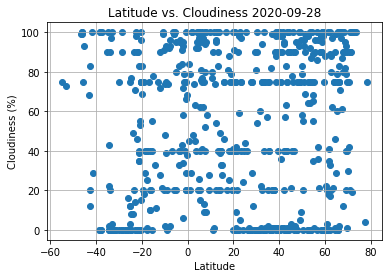

In [31]:
#creating var for cloudiness
y3 = scatterplotdata['Cloudiness']
#plotting scatter
plt.scatter(x,y3)
#adding titels/labels
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title(f'Latitude vs. Cloudiness {today}')
plt.grid()

#saving figure
plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig3.png")

plt.show()

In [ ]:
Latitude vs. Wind Speed

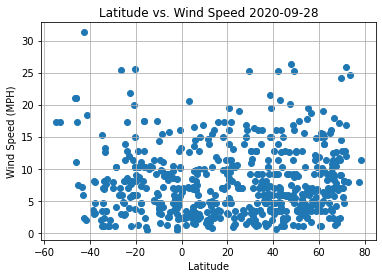

In [32]:
#creating var for windspeed
y4 = scatterplotdata['Wind Speed']
#creating scatter plot
plt.scatter(x,y4)
#adding title/labesl
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (MPH)')
plt.title(f'Latitude vs. Wind Speed {today}')
plt.grid()

plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig4.png")
plt.show()

Linear Regression

In [38]:
# Create a function to create Linear Regression plots. The function also takes in var for line equation placement on charts

# a couple print statements to print the r-squre value and line equation and adding labels to charts that are going to be the same

def plot_linear_regression(x_values, y_values, title, text_coordinates):
    
    # Run regresson on southern hemisphere
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Plot
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,text_coordinates,fontsize=15,color="red")
    plt.xlabel('Latitude')
    plt.ylabel(title)

    print(f"The r-value is: {rvalue**2}")
    
    plt.show()

In [40]:
# Create Northern and Southern Hemisphere DataFrames

Northern = scatterplotdata[scatterplotdata['Lat'] >= 0]

Southern = scatterplotdata[scatterplotdata['Lat'] < 0]

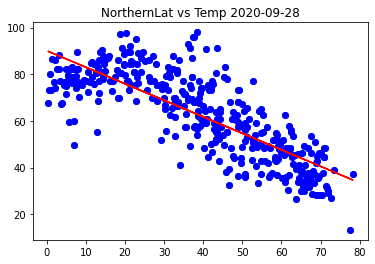

In [43]:
#Northern Hemisphere: Max Temp vs. Latitude Linear Regression

#setting x var for norther latitude point and setting y var
x_north = Northern["Lat"]
y_nTemp = Northern["Max Temp"]
#making scatter plot
plt.scatter(x_north,y_nTemp)
#adding title
plt.title(f'NorthernLat vs Temp {today}')
#running linear regression function
linearregress(x_north,y_nTemp,15,40,"Temperature(°F)")

#saving figure
plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig5.png")
plt.show()

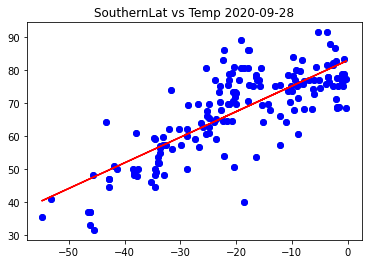

In [44]:
#Southern Hemisphere - Max Temp vs. Latitude Linear Regression

#setting x var for southern latitude point and setting y var
x_south = Southern["Lat"]
y_sTemp = Southern["Max Temp"]
#creating scatter plot
plt.scatter(x_south, y_sTemp)
#adding title
plt.title(f'SouthernLat vs Temp {today}')
#calling linear regression fuction
linearregress(x_south, y_sTemp,-55,80,"Temperature(°F)")

#saving figure
plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig6.png")
plt.show()

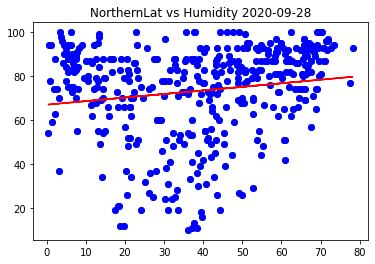

In [46]:
# Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

#setting y var
y_nHum = Northern["Humidity"]
#creating scatter plot
plt.scatter(x_north, y_nHum)
#adding title
plt.title(f'NorthernLat vs Humidity {today}')
#calling linear regression function
linearregress(x_north, y_nHum,0,10,'Humidity (%)')

#saving figure
plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig6.png")
plt.show()

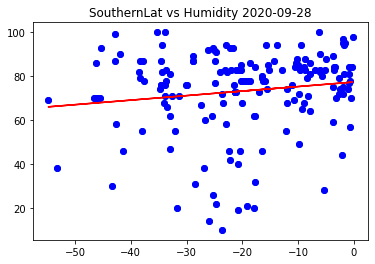

In [47]:
#Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

#setting y var
y_sHum=Southern["Humidity"]
#creating scatter plot
plt.scatter(x_south,y_sHum)
#adding title
plt.title(f'SouthernLat vs Humidity {today}')
#calling linear regression function
linearregress(x_south,y_sHum,-50,20,'Humidity (%)')

#saving figure
plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig7.png")
plt.show()

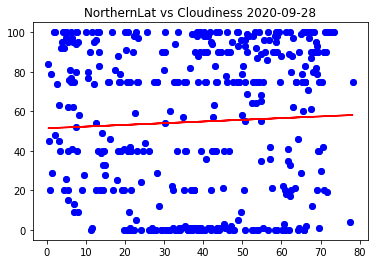

In [48]:

#setting y var
y_nClo = Northern["Cloudiness"]
#creating scatter plot
plt.scatter(x_north,y_nClo)
#adding title
plt.title(f'NorthernLat vs Cloudiness {today}')
#calling linear regression function
linearregress(x_north,y_nClo,5,60,"Cloudiness (%)")

#saving figure
plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig7.png")
plt.show()

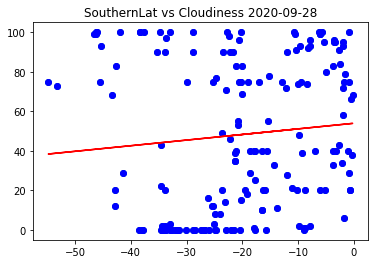

In [49]:
#setting y var
y_sClo = Southern["Cloudiness"]
#creating scatter plot
plt.scatter(x_south,y_sClo)
#adding title
plt.title(f'SouthernLat vs Cloudiness {today}')
#calling linear regression function
linearregress(x_south,y_sClo,-55,60,"Cloudiness (%)")

#saving figure
plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig8.png")
plt.show()

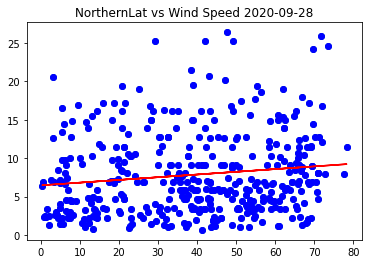

In [52]:
#setting y var
y_nWind= Northern["Wind Speed"]
#creating scatter plot
plt.scatter(x_north, y_nWind)
#adding title
plt.title(f'NorthernLat vs Wind Speed {today}')
#calling linear regression function
linearregress(x_north, y_nWind,0,25, "Wind Speed (mph)")

#saving figure
plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig9.png")
plt.show()

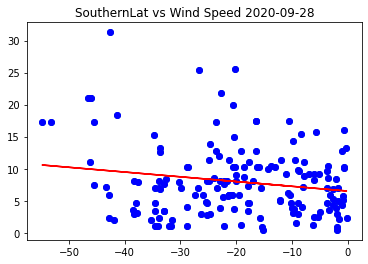

In [51]:
#setting y var
y_sWind = Southern["Wind Speed"]
#creating scatter plot
plt.scatter(x_south, y_sWind)
#adding title
plt.title(f'SouthernLat vs Wind Speed {today}')
#calling linear regression function
linearregress(x_south, y_sWind,-55,15,"Wind Speed (mph)")

#saving figure
plt.savefig("/Users/sarahgrant/Desktop/BCHomeworks/pythonAPIs-challenge/WeatherPy/dataforscatterplots/Fig10.png")
plt.show()